# **Iris predict**

In [3]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [88]:
# Main function 
def predictIris(path, save = False):
    image_array = load_img(path)
    gray_image = convert_to_grayscale(image_array)
    
    print("############# BINARY IMAGE FOR PUPIL #############")
    binary_image_pupil = binarize_image(gray_image, X=4.5)   
    print("############# BINARY IMAGE FOR IRIS #############")
    binary_image_iris = binarize_image(gray_image, X=1.9)
    
    print("############# PUPIL EXTRACTED #############")
    (x_pupil, y_pupil, r_pupil) = clean_pupil(binary_image_pupil)
    print("############# IRIS EXTRACTED #############")
    r_iris = clean_iris(binary_image_iris)
      
    image_with_pupil = draw_circle(image_array, x_pupil, y_pupil, r_pupil)
    image_with_pupil_and_iris = draw_circle(image_with_pupil, x_pupil, y_pupil, r_iris)
    
    print("############# FOUND PUPIL AND IRIS #############")
    show_image(image_with_pupil_and_iris)
    
    if save:
        save_path = os.path.join("found", f'{os.path.basename(path)}_found.bmp')
        cv2.imwrite(save_path, image_with_pupil_and_iris)
        print(f"Image saved to {save_path}")
    
   
# Show image    
def show_image(image_array):
    plt.figure(figsize=(4, 4))
    plt.imshow(image_array)
    plt.axis("off") 
    plt.show()
    
# Load image
def load_img(path):
    image = Image.open(path)
    image_array = np.array(image)
    print("############# ORIGINAL EYE IMAGE #############")
    show_image(image_array)
    return image_array
    
# Convert to grayscale
def convert_to_grayscale(image_array):
    gray_image = np.zeros((image_array.shape[0], image_array.shape[1]), dtype=np.uint8)
    gray_image = np.mean(image_array, axis=2)
    gray_image = np.array(gray_image, dtype=np.uint8)
    print("############# GRAY IMAGE #############")
    show_image(np.dstack((gray_image, gray_image, gray_image)))
    return gray_image

# Binarize with threshold
def binarize_image(image_array, X):
    P = np.mean(image_array)
    threshold = P / X
    binary_image = np.zeros_like(image_array)
    binary_image[image_array > threshold] = 255
    show_image(np.dstack((binary_image, binary_image, binary_image)))
    return binary_image

# Clean pupil image
def clean_pupil(binary_image):
    kernel = np.array([[1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],], dtype=np.uint8)
    kernel_small = np.ones((3, 3), np.uint8)   

    clean_image = binary_image.copy()
    
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel)
    clean_image = cv2.erode(clean_image, kernel, iterations=2)
    clean_image = cv2.dilate(clean_image, kernel_small, iterations=1)
    # clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel)


    horizontal_projection, vertical_projection = show_projections(clean_image)
    return find_pupil(horizontal_projection, vertical_projection)

# Clean iris image
def clean_iris(binary_image):
    kernel_large = np.ones((7, 7), np.uint8)   
    kernel_medium = np.ones((5, 5), np.uint8)  
    kernel_small = np.ones((3, 1), np.uint8)   
    clean_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel_large)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel_medium)
    clean_image = cv2.erode(clean_image, kernel_small, iterations=1)
    final_iris = cv2.dilate(clean_image, kernel_medium, iterations=1)
    horizontal_projection, vertical_projection = show_projections(final_iris)   
    return find_iris(horizontal_projection, vertical_projection) 

# Show projections
def show_projections(binary_image):
    horizontal_projection = np.sum(binary_image, axis=1)  
    vertical_projection = np.sum(binary_image, axis=0)   
    height, width = binary_image.shape
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    axs[0, 0].imshow(np.dstack((binary_image, binary_image, binary_image)))
    axs[0, 0].set_title("Binary Image")
    axs[0, 0].axis("off")
    axs[1, 1].axis("off")
    rect = patches.Rectangle((0, 0), width, height, linewidth=3, edgecolor='red', facecolor='none')
    axs[0, 0].add_patch(rect)
    axs[0, 1].plot(horizontal_projection, range(height), color='blue', linewidth=2)
    axs[0, 1].set_title("Horizontal Projection")
    axs[0, 1].set_ylim(height, 0)  
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)
    axs[1, 0].plot(range(width), vertical_projection, color='red', linewidth=2)
    axs[1, 0].set_title("Vertical Projection")
    axs[1, 0].set_xlim(0, width)  
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    return horizontal_projection, vertical_projection

# Find pupil
def find_pupil(horizontal_projection, vertical_projection):
    y_pupil = int(np.median(np.where(horizontal_projection == np.min(horizontal_projection))[0]))
    x_pupil = int(np.median(np.where(vertical_projection == np.min(vertical_projection))[0]))

    horizontal_diff = np.abs(np.diff(np.array(horizontal_projection, dtype=np.int64)))
    vertical_diff = np.abs(np.diff(np.array(vertical_projection, dtype=np.int64)))
    
    pupil_edges_y = np.where(horizontal_diff > np.max(horizontal_diff) * 0.3)[0]
    pupil_edges_x = np.where(vertical_diff > np.max(vertical_diff) * 0.3)[0]
    if len(pupil_edges_y) > 1:
        r_pupil_y = (pupil_edges_y[-1] - pupil_edges_y[0]) // 2
    else:
        r_pupil_y = 0
    if len(pupil_edges_x) > 1:
        r_pupil_x = (pupil_edges_x[-1] - pupil_edges_x[0]) // 2
    else:
        r_pupil_x = 0 
    r_pupil = (r_pupil_x + r_pupil_y) // 2 # CZY TU LEPIEJ BRAĆ ŚREDNIĄ CZY JAKIŚ MAKS CZY COŚ INNEGO?
    return (x_pupil, y_pupil, r_pupil)

# Find iris
def find_iris(horizontal_projection, vertical_projection):
    horizontal_diff = np.abs(np.diff(np.array(horizontal_projection, dtype=np.int64)))
    vertical_diff = np.abs(np.diff(np.array(vertical_projection, dtype=np.int64)))

    iris_edges_y = np.where(horizontal_diff > np.max(horizontal_diff) * 0.4)[0]
    iris_edges_x = np.where(vertical_diff > np.max(vertical_diff) * 0.4)[0]

    if len(iris_edges_y) > 1:
        r_iris_y = (iris_edges_y[-1] - iris_edges_y[0]) // 2
    else:
        r_iris_y = 0

    if len(iris_edges_x) > 1:
        r_iris_x = (iris_edges_x[-1] - iris_edges_x[0]) // 2
    else:
        r_iris_x = 0 

    r_iris = (3 * r_iris_x + r_iris_y) // 4

    return r_iris

# Draw found iris and pupil
def draw_circle(image_array, x, y, r):
    image_with_circle = image_array.copy()
    image_with_circle = cv2.circle(image_with_circle, (x, y), r, (255, 0, 0), 1)
    return image_with_circle


## Simple example

############# ORIGINAL EYE IMAGE #############


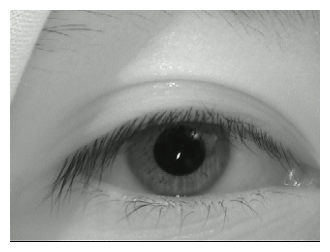

############# GRAY IMAGE #############


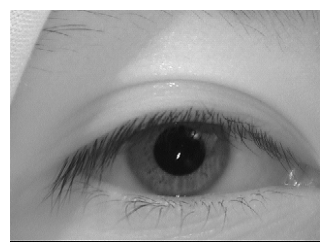

############# BINARY IMAGE FOR PUPIL #############


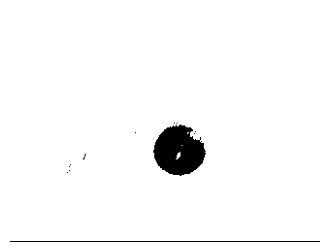

############# BINARY IMAGE FOR IRIS #############


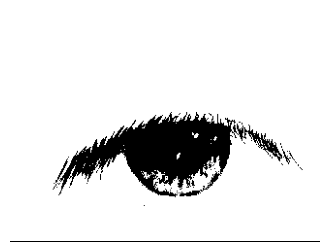

############# PUPIL EXTRACTED #############


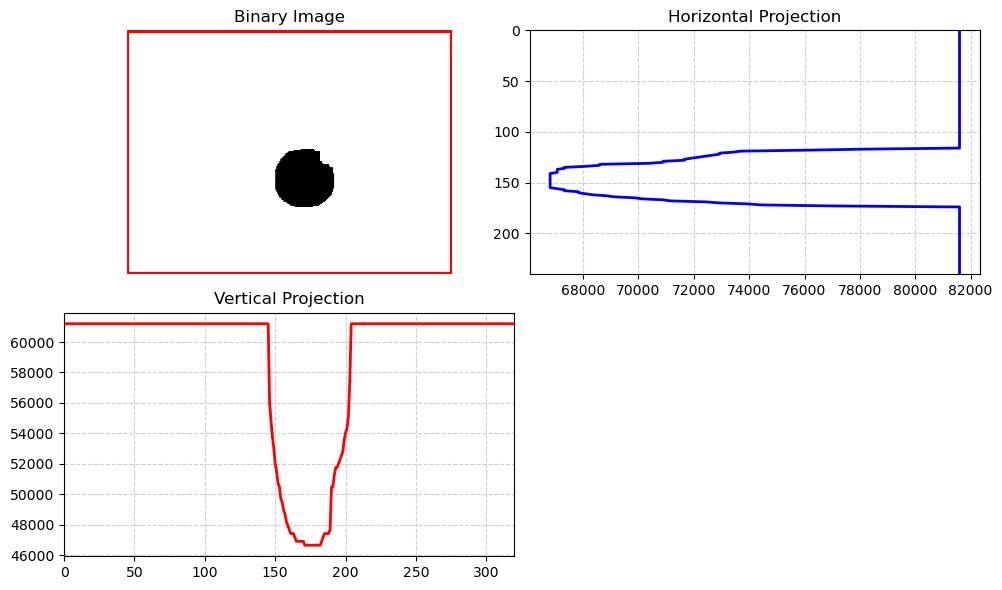

############# IRIS EXTRACTED #############


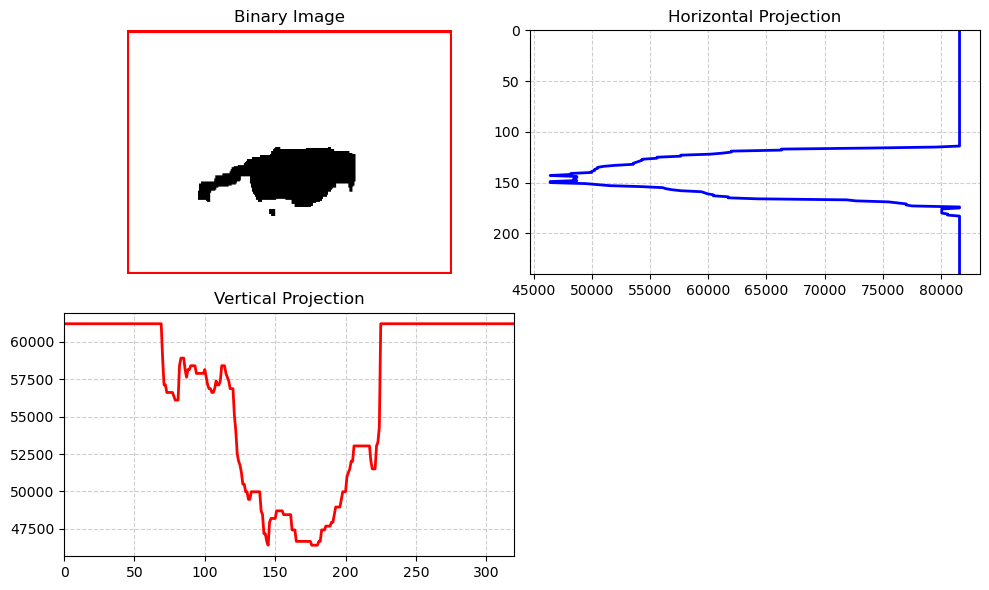

############# FOUND PUPIL AND IRIS #############


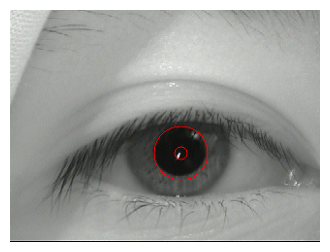

In [91]:
person_id = 20
eye = 'right'
photo_number = 3
path = os.path.join(f'data/eye_p{person_id:02d}_{eye}{photo_number}.bmp')

predictIris(path)